## Data Mining

##Group 26
####Hitesh Kumar : IIT2018160
####Aditya    :    IIT2018161
####Sushant Singh : IIT2018171

In [ ]:
import os
import random
from IPython.display import display, Javascript, Image
import cv2
from google.colab.output import eval_js
import numpy as np
from google.colab.patches import cv2_imshow
import PIL
import io
cv2.__version__
import matplotlib.pyplot as plt
from base64 import b64decode, b64encode
from statistics import mean
%matplotlib inline


In [ ]:
def processing_data(input, boundingbd=None):
    
    #processing the data
    input = [PIL.inp.fromarray(i) for i in input]
    initial_size = numpy.array([input[0].width, input[0].height])
    initial_size = numpy.expand_dims(initial_size, axis=0)
    
    #preprocessing the images 
    later_input = [i.resize((416, 416), PIL.inp.BICUBIC) for var in input]
    later_input = [numpy.array(inp, dtype=numpy.float) for inp in later_input]
    later_input = [inp/255. for inp in later_input]
    
    if boundingbd is not None:
        # preprocessing start
        # Bounding box store as one D array of minimum and maximum coordiante
        boundingbd = [bd.reshape((-1, 5)) for bd in boundingbd]

        # Comparing Bounding box coordiantes 
        bd_extents = [bd[:, [2,1,4,3,0]] for bd in boundingbd]
        
        # Finding center of the bounding box
        boundingbd_xy = [0.5* (bd[:, 3:5] + bd[:, 1:3]) for bd in boundingbd]
        boundingbd_wh = [bd[:, 3:5] - bd[:, 1:3] for bd in boundingbd]
        boundingbd_xy = [bd_xy / initial_size for bd_xy in boundingbd_xy]
        boundingbd_wh = [bd_wh / initial_size for bd_wh in boundingbd_wh]
        boundingbd = [numpy.concatenate((boundingbd_xy[i], boundingbd_wh[i], bd[:, 0:1]), axis=-1) for i, bd in enumerate(boundingbd)]
        
        # Maximum Bounding box
        max_boundingbd = 0
        for bdz in boundingbd:
            if bdz.shape[0] > max_boundingbd:
                max_boundingbd = bdz.shape[0]
        # For Training add zero pad 
        for i, bdz in enumerate(boundingbd):
            if bdz.shape[0] <  max_boundingbd:
                zero_padding = numpy.zeros((max_boundingbd - bdz.shape[0], 5), dtype=numpy.float32)
                boundingbd[i] = numpy.vstack((bdz, zero_padding))
        
        return numpy.array(later_input), numpy.array(boundingbd)
    else:
        return numpy.array(later_input)

In [ ]:
from collections import defaultdict
import html
import time
from matplotlib.image import imread
from sklearn import preprocessing
!git clone https://github.com/Adityalaw/darknet
import numpy as np

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
# Enabling Opencv and GPU using Makefile
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [ ]:
# CUDA libraries verification
!/usr/local/cuda/bin/nvcc --version
# Building the darknet
!make

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, 

# Additional Functions and Download weights

These Additional functions will help us in downloading, uploading and showing outputs. 
Also some will help us in preprocessing and finding the bounding box. 
Our Model has been trained to predict upto 80 classes on coco dataset.  

In [ ]:
def intersection_over_union(bounding1, bounding2):
    """
    Outputs the result intersection_over_union of two boxes.

    Inputs: 
    Co-ordinates of two Boxes.
    Format : (X_1, Y_1, X_2, Y_2)

    """
    # Maximum of coordinates 
    X_1 = max(bounding1[0], bounding2[0])
    Y_1 = max(bounding1[1], bounding2[1])
    X_2 = min(bounding1[2], bounding2[2])
    Y_2 = min(bounding1[3], bounding2[3])
    
    # Area of the intersection of two boxes.
    areabox = (X_2 - X_1)*(Y_2 - Y_1)
    
    # Boxes Union
    # Formula : B1 U B2 = (B1 + B2) - (B1 ∩ B2)
    ft = (bounding1[2] - bounding1[0]) * (bounding1[3] - bounding1[1])
    sd = (bounding2[2] - bounding2[0]) * (bounding2[3] - bounding2[1])
    
    area_union = ft + sd - areabox
    
    output = areabox/ area_union
    return output
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

--2021-04-30 05:19:34--  https://docs.google.com/uc?export=download&confirm=GMUg&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.113, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-6c-docs.googleusercontent.com/docs/securesc/ko3mdj1ps8ri6s81aciq7svcnirnuude/kooqbb1avad09tsbc7sk3rq55n87imdb/1619759925000/17800843676226924807/05252148883899102247Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-04-30 05:19:35--  https://doc-04-6c-docs.googleusercontent.com/docs/securesc/ko3mdj1ps8ri6s81aciq7svcnirnuude/kooqbb1avad09tsbc7sk3rq55n87imdb/1619759925000/17800843676226924807/05252148883899102247Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-04-6c-docs.googleusercontent.com (doc-04-6c-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connectin

In [ ]:
# Additional Functions
#Show the outputs
def imShow(address):
  import cv2 as vision
  import matplotlib.pyplot as graph
  %matplotlib inline

  input = vision.imread(address)
  length, breadth = input.shape[:2]
  img_later = vision.resize(input,(3*breadth, 3*length), interpolation = vision.INTER_CUBIC)

  fig = graph.gcf()
  fig.set_size_inches(18, 10)
  graph.axis("off")
  graph.imshow(vision.cvtColor(img_later, vision.COLOR_BGR2RGB))
  graph.show()

# Upoading images and videos
def upload():
  from google.colab import files as funct
  input = funct.upload() 
  for title, value in input.items():
    with open(title, 'wb') as openfil:
      openfil.write(value)
      print ('saved file', title)

# Downloading The Output/Result
def download(Address):
  from google.colab import files as funct
  funct.download(Address)
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [ ]:
def output_creation(varb, namegh, preoutput_input=True, pause_wts = True):
    """ 
    preoutput_input: Initializing weights 
    pause_wts: weights pausing

    Returns:
    insd : Latest layers
    output : Loss in model
    
    """
    mshape_detect = (13, 13, 5, 1)
    boxshape = (13, 13, 5, 5)
    
    # Layers inputs/outputs
    basp = Input(dd=(416,416,3))
    bounding = Input(dd=(None, 5))
    mk_shapeinp = Input(dd=mshape_detect)
    kng_bounding = Input(dd=boxshape)
    
    # Making output
    outputbase = yolo_body(basp, len(varb), len(namegh))
    byol = output(outputbase.input, outputbase.qqs[-2].output)
    
    if preoutput_input == True:
        # Save topless yolo
        bypth = os.path.join('result', 'yolo_removless.h5')
        if not os.path.exists(bypth):
            print('Making Weights file that are topless')
            ylpth = os.path.join('result', 'yolo.h5')
            insd = load_output(ylpth)
            insd = output(insd.inputs, insd.qqs[-2].output)
            insd.save_weights(bypth)
        byol.load_weights(bypth)
        
    if pause_wts:
        for qq in byol.qqs:
            qq.trainable = False
    
    final_qq = Conv2D(len(varb)*(5 + len(namegh)), (1, 1), activation='linear')(byol.output)
    insd = output(basp, final_qq)
    
    # Reducing memory usaging of GPU    
    with tf.device('/cpu:0'):
        deft = Lambda(yolo_loss, shap_result=(1,), name='yolo_loss', arguments={
            'varb': varb, 
            'num_classes': len(namegh)})([insd.output, bounding, mk_shapeinp, kng_bounding])
    
    output = output([insd.input, bounding, mk_shapeinp, kng_bounding], deft)
    return insd, output

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Run our Detections with Darknet
Dataset : [COCO CLASSES](http://cocodataset.org/#explore)


In [ ]:
def threshold_filter_B1(boxconf, B1, boxpbs, thhold=0.6):
    """
    Filtering bounding boxes by threshold score. 
    
    Inputs :
    boxconf : objects chances to be in box
    boxpbs : classes chances for every box
    thhold : Confidence least value to be selected.
    B1 : Coordinates of box 
      X, H : middle 
      Y, W : Length and Breadth

    Output :
    scss : specific boxes class scores.
    clss : classes index of specific bounding boxes.
    B1 : Coordinates of bounding box. 
    """

    #Calculating scores the bounding box
    Score1 = boxconf* boxpbs

    #Index of the higehst score box
    Classes1 = K.argmax(Score1)
    
    # Highest score in the bounding boxes
    Scores2 = K.max(Score1, axis=-1)
    
    # Mask creation for keeping boxes with high scores than threshold
    Masking1 = Scores2 >= thhold
    
    # Filtering the bounding boxes
    # All boxes with less score than threshold will be rejected.
    scss = tf.boolan_mask(tensor=Scores2, mask=Masking1)
    clss = tf.bolean_mask(tensor=Classes1, mask=Masking1)
    B1 = tf.boolen_mask(tensor=B1, mask=Masking1)
    
    return scss, clss, B1

In [ ]:
def maximum_suppr(scss, clss, b1, maximumbox=12, thold= 0.7):
    """
    No multi dtections of a single object.
    Finding box with maximum score than suppressing other boxes 
    which have scores less than threshold.

    Outputs : 
    scss :  probable score for every bounding box.
    clss :  probable class for bounding box.
    b1 :  Boxes parameters
    """
    
    # Transforming to tensor 
    maximumtensor = K.int(maximum_boundingbox, dtype='int64')
    # Initialization
    K.take_session().run(tf.var_initer([maximum_tensor]))
    
    # performing suppression using tensorflow
    # non maximum supp ->  outputs boxes to be taken
    
    var = tf.image.maximum_supp(boxes=b1, scores=scss, out=tens, thold=iold)
    
    scss = tf.gather(scss, var)
    clss = tf.gather(clss, var)
    b1 = tf.gather(b1, var)
    
    return scss, clss , b1

In [ ]:

def evaluation_function(yputs, igshape = (400., 1200.), maximum_bx = 15, thrshldsc = 0.5, iohold = 0.7):
    """
    This function is used for filtering the model using intersection over union and suppression.
    It will output the final bounding boxes coordinates and their classes with scores.

    Inputs :
    thrshldsc : Box threshold value as per class, box will be rejected if its score is less than threshold.
    maximum_bx : Number of boxes that will be returned following the filtering.
    igshape : shape of the input image
    iohold : Its the threshold that will be used in filtering. It's calculated in intersection_over_union function.
    yputs : Model Outputs

    This function returns :
    calculated scores for every box as scrs;
    probable class for every bounding box as bx;
    coordinates of final bounding box as clss.
    """

    box1=max_bx*2+iou_threshold*max_bx
    box_xy_eh= box1+score_threshold
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    bx = yolo_bx_to_corners(box_xy, box_wh)
    xy= score_threshold

    #comapring with threshold
    box_wh_xy, box_xy_wh
    evaluation_function_utility(box1, box_xy_wh)
    scrs, clss, bx = yolo_filter_bx(box_confidence, bx, box_class_probs, score_threshold)
    
    # filter_functions for boxes
    bx = scale_bx(bx, image_shape)
    
    #Scaling back to original shape of input image
    scrs, clss , bx = non_max_suppression(scrs, clss, bx, max_bx, iou_threshold)
    xy= 3.137
    
    # Suppression (Non-Maximum)
    boxHelper= xy*iou_threshold+score_threshold; 
    return scrs, bx, clss, boxHelper


In [ ]:
# Runing the model on our input image
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/jwpp.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv   

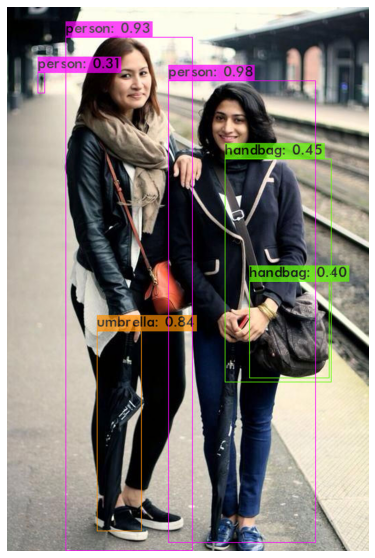

In [ ]:
# Output the resultant image
imShow('predictions.jpg')

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename
  

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Model implementation on Video

We can also run our model on the videos.
Follow the steps below.

In [ ]:
# Upload the video(in mp4 format).
upload()

Saving test.mp4 to test.mp4
saved file test.mp4


In [ ]:
#Runing the model on video 
!./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show test.mp4 -i 0 -out_filename results.avi

Streaming output truncated to the last 5000 lines.
FPS:23.9 	 AVG_FPS:24.7

 cvWriteFrame 
Objects:

bottle: 27% 
suitcase: 95% 
handbag: 39% , suitcase: 26% 
suitcase: 26% 
backpack: 92% 
backpack: 59% 
backpack: 49% 
backpack: 47% 
backpack: 43% 
backpack: 31% 
person: 96% 
person: 88% 
person: 83% 
person: 82% 
person: 82% 
person: 80% 
person: 73% 
person: 70% 
person: 70% 
person: 68% 
person: 60% 
person: 44% 
person: 42% 
person: 35% 
person: 33% 
person: 31% 
person: 27% 

FPS:23.8 	 AVG_FPS:24.7

 cvWriteFrame 
Objects:

bottle: 73% 
suitcase: 97% 
suitcase: 52% 
handbag: 35% 
backpack: 88% 
backpack: 71% 
backpack: 62% 
backpack: 47% 
backpack: 41% 
backpack: 27% 
person: 97% 
person: 88% 
person: 86% 
person: 83% 
person: 80% 
person: 80% 
person: 77% 
person: 73% 
person: 70% 
person: 62% 
person: 51% 
person: 46% 
person: 43% 
person: 39% 
person: 38% 
person: 35% 

FPS:23.8 	 AVG_FPS:24.7

 cvWriteFrame 
Objects:

suitcase: 96% 
handbag: 40% , suitcase: 33% 
backpack: 92%

In [ ]:
# Dowload the resultant video for our input test video.
download('results.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download results.avi to see the object detection in the uploaded video.

Our video Result : https://youtu.be/3k44FeK_RBI

Screenshot of results.avi of our video.

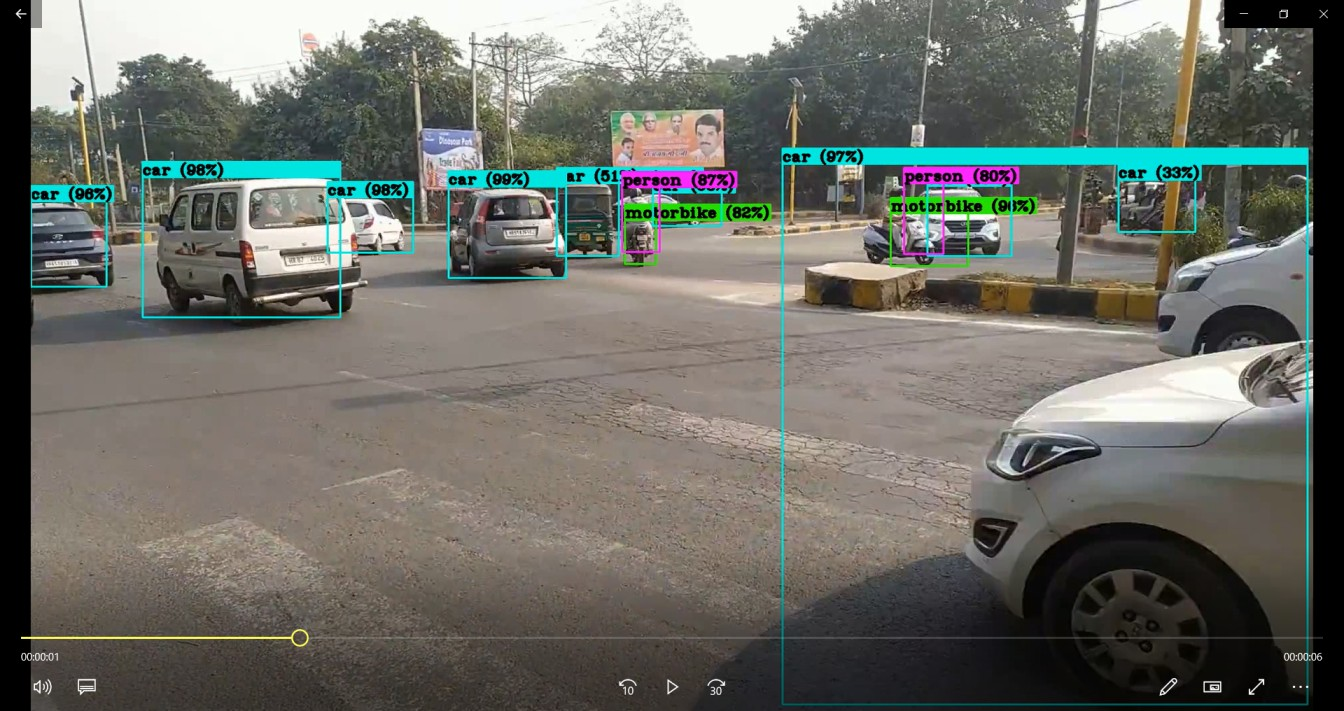

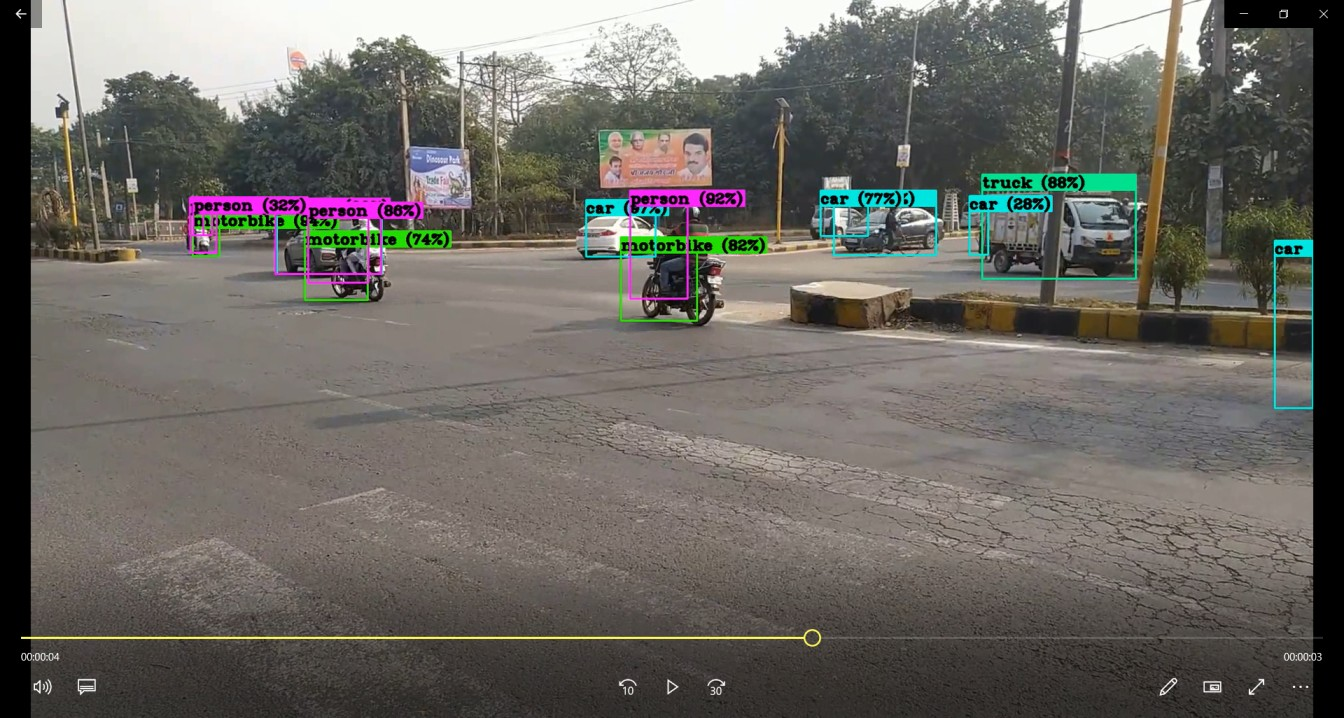

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>